## CNN with <250k parameters
### Imports
#### I'm only using basic libraries

In [1]:
import numpy as np 
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

### Setting the seed
#### This ensures reproducible results

In [2]:
tf.random.set_seed(13)

## Get the Kaggle provided data

In [3]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
Y = train_df['label']
X = train_df.drop('label', axis = 1)
del train_df
test = np.array(test_df).reshape(-1, 28, 28, 1) / 255.0
del test_df
print(np.shape(X))
print(np.shape(test))

(42000, 784)
(28000, 28, 28, 1)


### Get more data from the MNIST database
#### MNIST stands for 'Modified National Institute of Standards and Technology', and the MNIST database is a large, public, database of handwritten digits

In [4]:
(x_train_more, y_train_more), (x_test_more, y_test_more) = tf.keras.datasets.mnist.load_data()

train_more = np.concatenate([x_train_more, x_test_more], axis=0)
y_train_more = np.concatenate([y_train_more, y_test_more], axis=0)

Y_train_tf = y_train_more
X_train_tf = train_more.reshape(-1, 28*28)
print(X_train_tf.shape, Y_train_tf.shape)

(70000, 784) (70000,)


### Merge the Kaggle and MNIST data and then scale it down by 255
#### This normalizes the values to the range [0,1] and makes training faster and easier

In [5]:
X = np.concatenate((X, X_train_tf)).reshape(-1,28,28,1) / 255.0
Y = np.concatenate((Y, Y_train_tf))
print(X.shape, Y.shape)

(112000, 28, 28, 1) (112000,)


#### I am using ImageDataGenerator because I was messing around with data augmentation. This proved to be unnecessary.

In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
gen = ImageDataGenerator(validation_split = 0.2)

#### Helper function prints the graphs of training\val loss and accuracy so I can more easily discern whether there was any point in training the model for more epochs

In [7]:
def Charts(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()
    
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

## Creating the model
#### We use 3 sets of Conv2D with kernel size 3, MaxPool2D with pool size 2, and BatchNormalization, then we flatten the last BatchNormalizations output and add one more hidden dense layer.
#### We apply dropout after the flattening, and after the hidden dense layer to further reduce variance.
#### The setup of multiple Conv layers, then a Pool layer followed by a BatchNorm layer is somewhat of a standard practice (at least thats my impression after spending some time googling about the subject)

In [8]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, BatchNormalization, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
model = Sequential()

model.add(Conv2D(32, 3, padding = 'same', kernel_initializer = 'he_normal', activation = 'relu', input_shape = (28,28,1)))
model.add(MaxPool2D(2))
model.add(BatchNormalization())

model.add(Conv2D(64, 3, padding = 'same', kernel_initializer = 'he_normal', activation = 'relu'))
model.add(MaxPool2D(2))
model.add(BatchNormalization())

model.add(Conv2D(128, 3, padding = 'same', kernel_initializer = 'he_normal', activation = 'relu'))
model.add(MaxPool2D(2))
model.add(BatchNormalization())

model.add(Flatten())
model.add(Dropout(0.3))

model.add(Dense(128, kernel_initializer = 'he_normal', activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(10, activation = 'softmax'))

model.summary()
model.compile(optimizer = Adam(learning_rate = 3e-4), loss = 'sparse_categorical_crossentropy' , metrics = ['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 14, 14, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 64)         0         
 2D)                                                             
                                                        

### Train the model
#### We are adding an on_epoch_end callback, so that when we reach a high enough accuracy on the validation set, we stop training

In [9]:
class CustomCallbacks(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs = None):
        acc = logs['accuracy']
        val_acc = logs['val_accuracy']
        if acc >= 0.999 and val_acc >= 0.99995:
            self.model.stop_training = True

#### We train the model for 200 epochs with batch size 3200, which is the highest divisor of the number of samples that fits into memory

Epoch 1/200
56/56 [==============================] - 38s 661ms/step - loss: 0.8246 - accuracy: 0.7423 - val_loss: 0.6740 - val_accuracy: 0.8252
Epoch 2/200
56/56 [==============================] - 37s 663ms/step - loss: 0.1896 - accuracy: 0.9407 - val_loss: 0.3293 - val_accuracy: 0.9191
Epoch 3/200
56/56 [==============================] - 37s 663ms/step - loss: 0.1268 - accuracy: 0.9608 - val_loss: 0.2198 - val_accuracy: 0.9400
Epoch 4/200
56/56 [==============================] - 38s 677ms/step - loss: 0.0937 - accuracy: 0.9708 - val_loss: 0.1554 - val_accuracy: 0.9540
Epoch 5/200
56/56 [==============================] - 37s 663ms/step - loss: 0.0775 - accuracy: 0.9759 - val_loss: 0.1072 - val_accuracy: 0.9673
Epoch 6/200
56/56 [==============================] - 38s 677ms/step - loss: 0.0665 - accuracy: 0.9791 - val_loss: 0.0738 - val_accuracy: 0.9775
Epoch 7/200
56/56 [==============================] - 38s 678ms/step - loss: 0.0556 - accuracy: 0.9828 - val_loss: 0.0497 - val_accuracy:

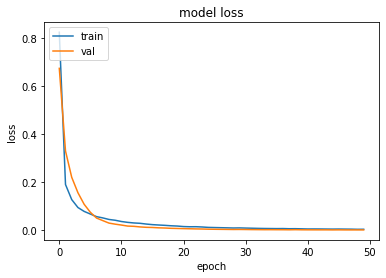

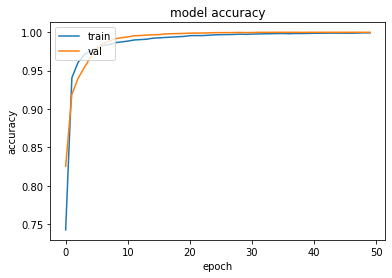

In [10]:
history = model.fit(gen.flow(X, y = Y, subset = 'training', batch_size = 1600), validation_data=gen.flow(X, y = Y, subset = 'validation', batch_size = 1600),
                    epochs = 200, verbose = 1, callbacks = [CustomCallbacks()])
Charts(history)

### We make the final submission

In [11]:
pred = model.predict(test)
print(pred.shape)
pred = tf.math.argmax(pred, axis = -1)
print(pred.shape)
pred = pd.Series(pred, name='Label')
pred.head()

image_id = pd.Series(range(1,28001),name='ImageId')
image_id.isnull().sum()
image_id.shape

pred = pd.concat([image_id,pred],axis=1)
pred.head()
pred.to_csv('submission.csv',index=False)

875/875 [==============================] - 4s 5ms/step
(28000, 10)
(28000,)
